# VRPTW with resource constraints

All vehicles need to be loaded before departing the depot and unloaded upon return. Since there are only two available loading docks, at most two vehicles can be loaded or unloaded at the same time. As a result, some vehicles must wait for others to be loaded, delaying their departure from the depot. The problem is to find optimal vehicle routes for the VRPTW that also meet the loading and unloading constraints at the depot.

Hapag-Lloyd AG is a German international shipping and container transportation company. Hapag-Lloyd was formed in 1970 through a merger of Hamburg-American Line and Norddeutscher Lloyd.

In this project, our goal is to load the Hapag-Lloyd AG containers from Hamburg port and deliver them to customers in different cities in Germany.
There are some limitations in this project that need to be considered:
* The loading of cargo at the port can only take place between 6:00 and 9:00, which gives a six-hour window for loading. During this time, all trucks must be loaded.
* Customers located in the northern cities should receive their cargo between 7:00 and 14:00, while those in the southern cities should receive it between 15:00 and 20:00. This means that the delivery times are restricted to specific hours in these regions.
* Each truck at the port takes 60 minutes to load, while unloading at each city takes 30 minutes. This needs to be factored into the overall scheduling.
* The port can load a maximum of two vehicles at the same time, and this needs to be taken into account when planning the schedule.
* It is assumed that the weight and volume of delivering cargo are equal for each city.

### Importing libraries

In [1]:
# Import the necessary libraries
from datetime import datetime
import googlemaps
import osmnx as ox
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import FancyArrowPatch
from matplotlib import cm
import folium
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2
import random
from folium.plugins import BeautifyIcon

### Creating time matrix by Google Map API

In [2]:
# Define the coordinates of the points you're interested in

#Depot
center_point = (53.55340283000828, 9.997909003468823)

# Hamburg
point_1 = (53.592900574926446, 10.136073409674138)

# Hanover
point_2 = (52.37619440445209, 9.736459735870287)

# Berlin
point_3 = (52.52766534668641, 13.338403831880242)

# Bielefeld
point_4 = (52.02583257589461, 8.521997484221258)

# Dortmund
point_5 = (51.53171668808929, 7.4155411495635555)

# Essen
point_6 = (51.46113854192261, 6.966025625760391)

# Düsseldorf
point_7 = (51.23763267393324, 6.720085588257423)

# Cologne
point_8 = (50.9660224784254, 6.86876705329854)

# Frankfurt
point_9 = (50.118651576053026, 8.662401288477877)

# Leipzig
point_10 = (51.33821620109022, 12.322835819058588)

# Dresden
point_11 = (51.043413223646546, 13.703228424480109)

# Berlin
point_12 = (52.4169106458904, 13.289290001425767)

# Nuremberg
point_13 = (49.45670425448668, 11.036674035050835)

# Stuttgart
point_14 = (48.776242928515785, 9.179513808480348)

# Munich
point_15 = (48.192339008572986, 11.498886222913976)

In [3]:
# Define your API key
api_key = 'your API key'

# Define the list of points
points = [center_point, point_1, point_2, point_3, point_4, point_5, point_6, point_7, point_8,
          point_9, point_10, point_11, point_12, point_13, point_14, point_15]

# Initialize the time matrix with NaN values
time_matrix = np.full((len(points), len(points)), np.nan)

# Loop over all pairs of points and calculate the travel time
for i in range(len(points)):
    for j in range(len(points)):
        if i != j:
            # Use Google Maps Distance Matrix API to get the travel time
            gmaps_client = googlemaps.Client(api_key)
            result = gmaps_client.distance_matrix(origins=points[i],
                                       destinations=points[j],
                                       mode='driving',
                                       departure_time='now',
                                       traffic_model='best_guess')
            # Extract the travel time from the API result and store it in the time matrix
            time_matrix[i, j] = result['rows'][0]['elements'][0]['duration']['value']

# Print the time matrix
print(time_matrix)

[[   nan  1653.  6382. 10889. 10002. 13226. 14858. 15968. 16298. 19124.
  14734. 18202. 11659. 23251. 25712. 28435.]
 [ 1684.    nan  7809. 10239. 10388. 13613. 15244. 16354. 16685. 19510.
  15409. 17229. 11135. 23638. 26098. 28822.]
 [ 6492.  6694.    nan 12269.  5232.  8457. 10088. 11198. 11529. 14590.
  10286. 13877. 11785. 18744. 20912. 23988.]
 [10927. 10225. 11116.    nan 14932. 18156. 19788. 20898. 21228. 20303.
   7256.  8623.  1918. 16549. 23750. 20958.]
 [10221. 10423.  5280. 19483.    nan  4769.  6400.  7511.  7841. 12774.
  14637. 17814. 14686. 16902. 19362. 22666.]
 [13340. 13543.  8399. 22157.  4776.    nan  2125.  3235.  4121. 10284.
  15987. 19680. 21576. 18252. 17381. 24148.]
 [14645. 14848.  9990. 25212.  6367.  2154.    nan  2334.  3698. 10207.
  17373. 21073. 24198. 18072. 16897. 23664.]
 [15809. 16011. 11198. 23396.  7575.  3354.  2364.    nan  2273.  9439.
  18527. 22221. 23247. 17304. 16603. 22897.]
 [16201. 16616. 11259. 21824.  7637.  4362.  3950.  2252.    nan

In [4]:
converted_time_matrix = np.nan_to_num(time_matrix)
converted_time_matrix /= 60
converted_time_matrix = np.round(converted_time_matrix)

### Plotting

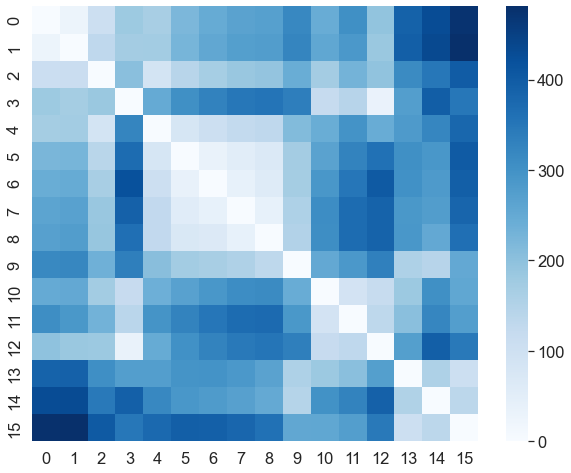

In [5]:
# plotting the heatmap of distance matrix
sns.set(font_scale=1.5)
plt.figure(figsize=(10, 8))

sns.heatmap(converted_time_matrix, cmap="Blues")
plt.show()

### adding unloading time for each city (30 minutes)

In [6]:
total_time_matrix = converted_time_matrix + 30
np.fill_diagonal(total_time_matrix, 0)

In [7]:

# Define the center of the map and the initial zoom level
center = (51.1657, 10.4515)
zoom = 6

# Create a map object
m = folium.Map(location=center, zoom_start=zoom)

# Add a marker for each city
i = 0
for point in points:
    folium.Marker(location=point, popup=i).add_to(m)
    i+=1
# Display the map
m

### Create the data

In [8]:
def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data['time_matrix'] = total_time_matrix
    data['time_windows'] = [
        (0, 180),  # depot
        (60, 480),  # 1
        (60, 480),  # 2
        (60, 480),  # 3
        (60, 480),  # 4
        (60, 480),  # 5
        (60, 480),  # 6
        (60, 480),  # 7
        (60, 480),  # 8
        (540, 840),  # 9
        (540, 840),  # 10
        (540, 840),  # 11
        (60, 480),  # 12
        (540, 840),  # 13
        (540, 840),  # 14
        (540, 840),  # 15
    ]
    data['num_vehicles'] = 3
    data['vehicle_load_time'] = 60
    data['vehicle_unload_time'] = 60
    data['depot_capacity'] = 2
    data['depot'] = 0
    return data

In [9]:
data = create_data_model()
manager = pywrapcp.RoutingIndexManager(len(data['time_matrix']),
                                           data['num_vehicles'], data['depot'])
routing = pywrapcp.RoutingModel(manager)

### Time callback

In [10]:
def time_callback(from_index, to_index):
    """Returns the travel time between the two nodes."""
    # Convert from routing variable Index to time matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data['time_matrix'][from_node][to_node]

transit_callback_index = routing.RegisterTransitCallback(time_callback)
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

### Set the cost of travel

In [11]:
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

### Add time window constraints

In [12]:
time = 'Time'
routing.AddDimension(
    transit_callback_index,
    0,  # allow waiting time
    6000,  # maximum time per vehicle
    False,  # Don't force start cumul to zero.
    time)
time_dimension = routing.GetDimensionOrDie(time)
# Add time window constraints for each location except depot.
for location_idx, time_window in enumerate(data['time_windows']):
    if location_idx == 0:
        continue
    index = manager.NodeToIndex(location_idx)
    time_dimension.CumulVar(index).SetRange(time_window[0], time_window[1])
# Add time window constraints for each vehicle start node.
for vehicle_id in range(data['num_vehicles']):
    index = routing.Start(vehicle_id)
    time_dimension.CumulVar(index).SetRange(data['time_windows'][0][0],
                                            data['time_windows'][0][1])
    
solver = routing.solver()
intervals = []
for i in range(data['num_vehicles']):
    # Add time windows at start of routes
    intervals.append(
        solver.FixedDurationIntervalVar(
            time_dimension.CumulVar(routing.Start(i)),
            data['vehicle_load_time'], 'depot_interval'))
    # Add time windows at end of routes.
    intervals.append(
        solver.FixedDurationIntervalVar(
            time_dimension.CumulVar(routing.End(i)),
            data['vehicle_unload_time'], 'depot_interval'))
    
depot_usage = [1 for i in range(len(intervals))]
solver.Add(
    solver.Cumulative(intervals, depot_usage, data['depot_capacity'],
                        'depot'))

### Set search parameters (PATH_CHEAPEST_ARC)

Here I choose the PATH_CHEAPEST_ARC, however you can try the other methods that are defined in: https://developers.google.com/optimization/routing/routing_options#first_solution_strategy

In [13]:
# Setting first solution heuristic.
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

### Add the solution printer

In [14]:
def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f'Objective: {solution.ObjectiveValue()}')
    time_dimension = routing.GetDimensionOrDie('Time')
    total_time = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        while not routing.IsEnd(index):
            time_var = time_dimension.CumulVar(index)
            plan_output += '{0} Time({1},{2}) -> '.format(
                manager.IndexToNode(index), solution.Min(time_var),
                solution.Max(time_var))
            index = solution.Value(routing.NextVar(index))
        time_var = time_dimension.CumulVar(index)
        plan_output += '{0} Time({1},{2})\n'.format(manager.IndexToNode(index),
                                                    solution.Min(time_var),
                                                    solution.Max(time_var))
        plan_output += 'Time of the route: {}min\n'.format(
            solution.Min(time_var))
        print(plan_output)
        total_time += solution.Min(time_var)
    print('Total time of all routes: {}min'.format(total_time))

### Solve and print the solution

In [15]:
# Solve the problem.
solution = routing.SolveWithParameters(search_parameters)

# Print solution on console.
if solution:
    print_solution(data, manager, routing, solution)
else:
    print('No solution found !')

Objective: 3489
Route for vehicle 0:
0 Time(0,0) -> 5 Time(250,250) -> 6 Time(315,315) -> 7 Time(384,384) -> 8 Time(452,452) -> 9 Time(633,633) -> 14 Time(806,806) -> 0 Time(1265,1265)
Time of the route: 1265min

Route for vehicle 1:
0 Time(2,2) -> 1 Time(60,60) -> 3 Time(261,261) -> 12 Time(323,323) -> 15 Time(700,700) -> 13 Time(836,836) -> 0 Time(1253,1253)
Time of the route: 1253min

Route for vehicle 2:
0 Time(60,165) -> 4 Time(257,362) -> 2 Time(375,480) -> 10 Time(576,681) -> 11 Time(696,801) -> 0 Time(1033,1138)
Time of the route: 1033min

Total time of all routes: 3551min


### creating list of routes

In [16]:
def get_routes(solution, routing, manager):
    """Get vehicle routes from a solution and store them in an array."""
    # Get vehicle routes and store them in a two dimensional array whose
    # i,j entry is the jth location visited by vehicle i along its route.
    routes = []
    for route_nbr in range(routing.vehicles()):
        index = routing.Start(route_nbr)
        route = [manager.IndexToNode(index)]
        while not routing.IsEnd(index):
            index = solution.Value(routing.NextVar(index))
            route.append(manager.IndexToNode(index))
        routes.append(route)
    return routes

In [17]:
routes = get_routes(solution, routing, manager)
# Display the routes.
for i, route in enumerate(routes):
    print('Route', i+1, route)

Route 1 [0, 5, 6, 7, 8, 9, 14, 0]
Route 2 [0, 1, 3, 12, 15, 13, 0]
Route 3 [0, 4, 2, 10, 11, 0]


### Finall plot

In [19]:
# Define the center of the map and the initial zoom level
center = (51.1657, 10.4515)
zoom = 6

# Create a map object
m = folium.Map(location=center, zoom_start=zoom)

# Create a map object
m = folium.Map(location=center, zoom_start=zoom)

# Add a marker for each city
i = 0
for point in points:
    folium.Marker(location=point, popup=i).add_to(m)
    i+=1

number_of_colors = len(routes)

color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]


i = 0
for route in routes:
    l = []
    for node in route:
        l.append(points[node])   
    line = folium.PolyLine(locations=l, color=color[i], weight=4).add_to(m)
    i += 1

# Display the map
m